In [ ]:
# Questions
# 1. Can wearable sensor data predict tremor score? 
# 2. Can wearable sensor data predict whether tremor is present?
# 3. Can wearable sensor data predict whether tremor symptom is sever (score>2)? 

# Using sensor data from the non-voluntary-movement task group can predict sever tremor well (up-sampling- max/2)

# Metrics

# Would gender, age, diagnosis history, motor task can help with model prediction?
# If motor tasks affect model performance, should we predict motor tasks using sensor data first?
# (Stacked models)

In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions, sqrt, argmax, arange
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Self-defined functions
from Utilities import pdVarianceThreshold, pdSelectKBest, train_val_test_split, upsampling, SelectBestClf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Model_validation", "GENEActiv_tremor")

# Load data

In [3]:
# Load score data
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

# Tremor: merge score 3 and 4
df_score['tremor_GENEActivHand'].loc[df_score['tremor_GENEActivHand']==4]=3

In [4]:
# load sensor feature data
subject_ids = df_score.subject_id.unique()
df_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_feature_sb = pd.read_pickle(feature_file_path)
    df_feature = pd.concat([df_feature,df_feature_sb])
df_feature = df_feature.reset_index(drop=True)

In [5]:
# load clinical features
meta_file_path = os.path.join(direc, 'Feature_extraction','metadata_features.pkl')
df_meta = pd.read_pickle(meta_file_path)

# drop subject_id and task_code 
# df_meta.drop(columns = ['subject_id', 'task_code'])
df_meta = df_meta.drop(columns = 'subject_id')

# One-hot encoding clinical/ categorical features
categorical_columns = df_meta.columns
for column in categorical_columns:
    tempdf = pd.get_dummies(df_meta[column], prefix=column)
    df_meta = pd.merge(
        left=df_meta,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_meta = df_meta.drop(columns=column)
print(df_meta.shape)

(6909, 69)


In [6]:
# Create a new label for each question

# Tremor
# 1. Can wearable sensor data predict tremor score? 
# df_score['newTremorLabel_GENEActivHand'] = df_score['tremor_GENEActivHand']
# title_name = 'Tremor score'
# save_name = 'tremor_score'
# xtick_name = [0,1,2,3,4]
# bin_range = range(5)

# 2. Can wearable sensor data predict whether tremor is present?
is_tremor = df_score['tremor_GENEActivHand'].astype(int)>0
df_score['newTremorLabel_GENEActivHand'] = np.nan
df_score['newTremorLabel_GENEActivHand'].loc[is_tremor] = 1
df_score['newTremorLabel_GENEActivHand'].loc[~is_tremor] = 0

title_name = 'is tremor'
save_name = 'is_tremor'
xtick_name = [0,1]
bin_range = range(3)
recall_1_threshold = 0.8

# 3. Can wearable sensor data predict whether tremor symptom is sever (score>2)? 
# is_sever_tremor = df_score['tremor_GENEActivHand'].astype(int)>2
# df_score['newTremorLabel_GENEActivHand'] = np.nan
# df_score['newTremorLabel_GENEActivHand'].loc[is_sever_tremor] = 1
# df_score['newTremorLabel_GENEActivHand'].loc[~is_sever_tremor] = 0

# title_name = 'is sever tremor (tremor score>2)'
# save_name = 'is_sever_tremor'
# xtick_name = [0,1]
# bin_range = range(3)
# recall_1_threshold = 0.9


In [ ]:
# # Test mild tremor after removing sever tremor
# is_sever_tremor = df_score['tremor_GENEActivHand'].astype(int)>2
# df_score = df_score.loc[~is_sever_tremor] 
# df_feature = df_feature.loc[~is_sever_tremor] 
# df_meta = df_meta.loc[~is_sever_tremor] 
# print(df_score.shape)

array([4677, 2232], dtype=int64)

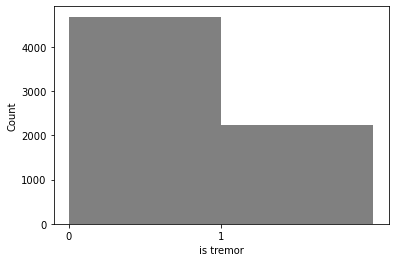

In [7]:
# Get new score distribution
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)

# score distribution
counts, bin_edges = np.histogram(score,bins = bin_range)
fig, ax = plt.subplots()
ax.hist(score, bins = bin_range, histtype='bar', color = 'grey')
ax.set_xlabel(title_name)
ax.set_ylabel('Count')
ax.set_xticks(xtick_name)
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

# Upsample

In [ ]:
upsample_size = round(max(counts)/2)
upsampled_df_score, upsampled_df_feature, upsampled_df_meta = upsampling(df_score, df_feature, df_meta, upsample_size, counts, score)
print('upsampled features:' + str(upsampled_df_feature.shape))
print('upsampled scores:' + str(upsampled_df_score.shape))
print('upsampled meta:' + str(upsampled_df_meta.shape))

In [ ]:
df_feature = upsampled_df_feature
df_score = upsampled_df_score
df_meta = upsampled_df_meta

# Feature selection

In [8]:
## Get data
# Combine sensor features with clinical features
df = pd.concat([df_feature, df_meta], axis=1) 
# Get scores
score = df_score['newTremorLabel_GENEActivHand'].values
score = np.array(score, dtype=float)

## Set parameters
varThreshold = 0.0001
k_num = 10

## Feature selection
# Remove features with nan
df2 = df.dropna(axis=1)

# Remove features with zero variance
df3 = pdVarianceThreshold(df2,varThreshold)

# Univariant selection
df4 = pdSelectKBest(df3,score,k_num)


# Select Best Classifier

In [9]:
# Train/Validation/Test Split
subject_id = df_score['subject_id']
X_train_valid, y_train_valid, X_train, y_train,  X_valid, y_valid, X_test, y_test = train_val_test_split(df4, score, subject_id)


In [10]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
#     "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150, 200, 250]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [2, 4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
#     "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [11]:
# Classifier evaluation
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                           'Accuracy': np.zeros(len(classifiers)),
                           'F1_macro': np.zeros(len(classifiers)),
                           'F1_micro': np.zeros(len(classifiers)),
                           'F1_weighted': np.zeros(len(classifiers)),
                           'F1_0': np.zeros(len(classifiers)),
                           'F1_1': np.zeros(len(classifiers)),                               
                           'Precision_0': np.zeros(len(classifiers)),
                           'Precision_1': np.zeros(len(classifiers)),
                           'Recall_0': np.zeros(len(classifiers)),
                           'Recall_1': np.zeros(len(classifiers)),
                           'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    Accuracy = accuracy_score(y_valid, y_pred).round(2)
    F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
    F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
    F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
    F1_class = f1_score(y_valid, y_pred, average = None).round(2)
    Precision = precision_score(y_valid, y_pred, average = None).round(2)
    Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         

    valid_scores.iloc[i,1]=Accuracy
    valid_scores.iloc[i,2]=F1_macro
    valid_scores.iloc[i,3]=F1_micro
    valid_scores.iloc[i,4]=F1_weighted
    valid_scores.iloc[i,5]=F1_class[0]
    valid_scores.iloc[i,6]=F1_class[1]
    valid_scores.iloc[i,7]=Precision[0]
    valid_scores.iloc[i,8]=Precision[1] 
    valid_scores.iloc[i,9]=Recall[0]
    valid_scores.iloc[i,10]=Recall[1]

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)


    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,11])
    print('')
    i+=1


Model: LogisticRegression
Training time (mins): 0.12

Model: KNN
Training time (mins): 0.01

Model: RandomForest
Training time (mins): 0.28

Model: XGBoost
Training time (mins): 0.33

Model: LGBM
Training time (mins): 0.08

Model: NaiveBayes
Training time (mins): 0.0



In [12]:
valid_scores

,Classifer,Accuracy,F1_macro,F1_micro,F1_weighted,F1_0,F1_1,Precision_0,Precision_1,Recall_0,Recall_1,Training time
0,LogisticRegression,0.69,0.69,0.69,0.69,0.69,0.69,1.00,0.52,0.53,1.00,0.12
1,KNN,0.69,0.68,0.69,0.70,0.74,0.61,0.83,0.53,0.68,0.72,0.01
2,RandomForest,0.68,0.68,0.68,0.69,0.69,0.67,0.96,0.52,0.54,0.95,0.28
3,XGBoost,0.69,0.68,0.69,0.70,0.75,0.60,0.81,0.54,0.70,0.69,0.33
4,LGBM,0.70,0.69,0.70,0.71,0.75,0.63,0.84,0.54,0.67,0.75,0.08
5,NaiveBayes,0.69,0.69,0.69,0.69,0.69,0.68,1.00,0.52,0.53,1.00,0.00


In [13]:
best_clf_summary = SelectBestClf(valid_scores, recall_1_threshold, clf_best_params)
best_clf = best_clf_summary[2]
print(best_clf)

LogisticRegression


In [ ]:
# Move threshold of classifier 

In [14]:
# Choose the best threshold
# recall is above the recall threshold
# select the best F1 score 

# predict probabilities
yhat = clf.predict_proba(X_valid)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_valid, probs)
# select recall is above the recall threshold                
is_good_recall = recall > recall_1_threshold
# choose the maximal precision
# ix = np.argmax(precision[is_good_recall])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)


# new_y_pred = probs > thresholds[ix]
# Accuracy = accuracy_score(y_valid, y_pred).round(2)
# F1_micro = f1_score(y_valid, new_y_pred, average = 'micro').round(2)
# Precision = precision_score(y_valid, new_y_pred, average = None).round(2)
# Recall = recall_score(y_valid, new_y_pred, average = None).round(2)    

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.980212, F-Score=0.686


In [ ]:
F1_micro

In [ ]:
Precision

In [ ]:
Recall

In [ ]:
# ROC curve
# predict probabilities
yhat = clf.predict_proba(X_valid)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, probs)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=best_clf)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

(array([518.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2., 974.,   0.,   0.,   0.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08]),
 <BarContainer object of 54 artists>)

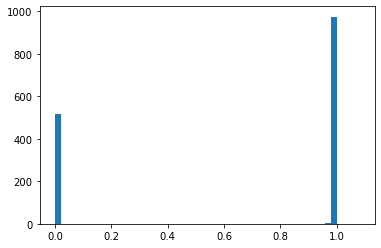

In [15]:
plt.hist(probs, bins = np.arange(0, 1.1, 0.02))

In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_valid, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


In [ ]:
# PR curve
precision, recall, thresholds = precision_recall_curve(y_valid, probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the pr curve for the model
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label=best_clf)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()


In [ ]:
clf_summary = pd.DataFrame()
for t,task,task_name in zip(range(len(task_groups)),task_groups, task_group_names):
    is_tasks = df_score['task_code'].isin(task).tolist()
    df_feature_task = df_feature[is_tasks]
    df_score_task = df_score[is_tasks]
    df_meta_task = df_meta[is_tasks]
    print(task_name)
    
    # Use only sensor features
    df_task = df_feature_task
    # Combine sensor features with clinical features
#     df_task = pd.concat([df_feature_task, df_meta_task], axis=1)
    
    # Remove features with nan
    df_feature2 = df_task.dropna(axis=1)

    # Remove features with zero variance
    sel = VarianceThreshold(threshold=0.0001)
    df_feature3 = sel.fit_transform(df_feature2)
    filter3 = sel.get_support()
    feature_names2 = df_feature2.columns
    feature_names3 = feature_names2[filter3]
    df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

    # Get scores
    score = df_score_task['newTremorLabel_GENEActivHand'].values
    score = np.array(score, dtype=float)

    # Univariate Selection
    test = SelectKBest(score_func=f_classif, k=10)
    df_feature4 = test.fit_transform(df_feature3, score)
    filter4 = test.get_support()
    feature_names4 = feature_names3[filter4]
    df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

    # PCA
    X=df_feature4.values
    pca = PCA(n_components=3)
    X_new = pca.fit_transform(X)
    
    # Train/Validation/Test Split
    is_train = df_score_task['subject_id'].isin(sb_train).tolist()
    is_val = df_score_task['subject_id'].isin(sb_val).tolist()
    is_test = df_score_task['subject_id'].isin(sb_test).tolist()
    is_train_val = df_score_task['subject_id'].isin(sb_train) | df_score_task['subject_id'].isin(sb_val)
    is_train_val = is_train_val.tolist()
    
    X_train_valid = X_new[is_train_val,:]
    y_train_valid = score[is_train_val]
    X_train = X_new[is_train,:]
    y_train = score[is_train]
    X_valid = X_new[is_val,:]
    y_valid = score[is_val]
    X_test = X_new[is_test,:]
    y_test = score[is_test]
    
    # Classifier evaluation
    i=0
    clf_best_params=classifiers.copy()
    valid_scores=pd.DataFrame({'Classifer':classifiers.keys(),
                               'Accuracy': np.zeros(len(classifiers)),
                               'F1_macro': np.zeros(len(classifiers)),
                               'F1_micro': np.zeros(len(classifiers)),
                               'F1_weighted': np.zeros(len(classifiers)),
                               'F1_0': np.zeros(len(classifiers)),
                               'F1_1': np.zeros(len(classifiers)),                               
                               'Precision_0': np.zeros(len(classifiers)),
                               'Precision_1': np.zeros(len(classifiers)),
                               'Recall_0': np.zeros(len(classifiers)),
                               'Recall_1': np.zeros(len(classifiers)),
                               'Training time': np.zeros(len(classifiers))})
    
    for key, classifier in classifiers.items():
        start = time.time()
        clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

        # Train and score
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        Accuracy = accuracy_score(y_valid, y_pred).round(2)
        F1_macro = f1_score(y_valid, y_pred, average = 'macro').round(2)
        F1_micro = f1_score(y_valid, y_pred, average = 'micro').round(2)
        F1_weighted = f1_score(y_valid, y_pred, average = 'weighted').round(2)
        F1_class = f1_score(y_valid, y_pred, average = None).round(2)
        Precision = precision_score(y_valid, y_pred, average = None).round(2)
        Recall = recall_score(y_valid, y_pred, average = None).round(2)                                         
        
        valid_scores.iloc[i,1]=Accuracy
        valid_scores.iloc[i,2]=F1_macro
        valid_scores.iloc[i,3]=F1_micro
        valid_scores.iloc[i,4]=F1_weighted
        valid_scores.iloc[i,5]=F1_class[0]
        valid_scores.iloc[i,6]=F1_class[1]
        valid_scores.iloc[i,7]=Precision[0]
        valid_scores.iloc[i,8]=Precision[1] 
        valid_scores.iloc[i,9]=Recall[0]
        valid_scores.iloc[i,10]=Recall[1]

        # Save trained model
        clf_best_params[key]=clf.best_params_

        # Print iteration and training time
        stop = time.time()
        valid_scores.iloc[i,11]=np.round((stop - start)/60, 2)
        
        
        print('Model:', key)
        print('Training time (mins):', valid_scores.iloc[i,11])
        print('')
        i+=1
    
    # Select best classifier based on recall threshold for the positive class and F1 score
    is_good_recall_1 = valid_scores['Recall_1'] > recall_1_threshold
    if sum(is_good_recall_1) == 0: # recall 1 is below the threshold 
        best_recall_1 = valid_scores['Recall_1'].max()
        is_best = valid_scores['Recall_1'] == best_recall_1
        if sum(is_best)>1: # duplicate max recall scores -> compare F1 score
            max_index = valid_scores['F1_micro'].loc[is_best].idxmax()
        else:
            max_index = valid_scores['Recall_1'].idxmax() 
        best_clf = valid_scores['Classifer'].iloc[max_index]
        training_time = valid_scores['Training time'].iloc[max_index]
        best_clf_params = clf_best_params[best_clf]
        best_F1_micro = valid_scores['F1_micro'].iloc[max_index]

    else: # recall 1 is above the threshold -> select the best classifier based on F1 score
        best_F1_micro = valid_scores['F1_micro'].loc[is_good_recall_1].max()
        is_best = valid_scores['F1_micro'] == best_F1_micro
        if sum(is_best)>1: # duplicate max F1 scores -> compare recall score
            max_index = valid_scores['Recall_1'].loc[is_best].idxmax()
        else:
            max_index = valid_scores['F1_micro'].idxmax() 
        best_clf = valid_scores['Classifer'].iloc[max_index]
        training_time = valid_scores['Training time'].iloc[max_index]
        best_clf_params = clf_best_params[best_clf] 
        best_recall_1 = valid_scores['Recall_1'].iloc[max_index]
    
    clf_summary_round = pd.DataFrame({'title': [title_name],
             'task_group': [task_name],
             'max_sample_size': [max(counts)],
             'upsample_size': [upsample_size],
             'best_F1_micro': [best_F1_micro],            
             'best_recall_1': [best_recall_1],
             'best_clf': [best_clf],
             'clf_best_params': [best_clf_params],                         
             'valid_scores': [valid_scores]},
              index=[t])
    clf_summary = pd.concat([clf_summary,clf_summary_round])

In [ ]:
clf_summary

In [ ]:
# save validation_summary
save_file_path = os.path.join(save_path, save_name + '_validation.pkl')
# save_file_path = os.path.join(save_path, save_name + '_validation_with_clinical_features.pkl')
clf_summary.to_pickle(save_file_path)

In [ ]:
clf_summary['valid_scores'].loc[0]

In [ ]:
clf_summary['valid_scores'].loc[1]

In [ ]:
clf_summary['valid_scores'].loc[2]

In [ ]:
clf_summary['valid_scores'].loc[3]

# Summary

In [ ]:
# load validation score data
questions = ['is_tremor', 'is_sever_tremor']

df_valid = pd.DataFrame()
for q in questions:
    file_path = os.path.join(save_path, q + '_validation.pkl')
    df_valid_q = pd.read_pickle(file_path)
    df_valid = pd.concat([df_valid,df_valid_q])
df_valid = df_valid.reset_index(drop=True)

In [ ]:
df_valid

In [ ]:
df_valid['valid_scores'].iloc[0]

In [ ]:
df_valid_summary = df_valid[['title','task_group']].copy


In [ ]:
row = 0
clf_valid_scores = df_valid['valid_scores'].iloc[row]
# Select best F1 score
best_F1_score = max(clf_valid_scores['F1_weighted'])
# Select best classifier based on recall score for positive class
best_recall_1 = max(clf_valid_scores['Recall_1'])
best_clf = clf_valid_scores['Classifer'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
training_time = clf_valid_scores['Training time'].loc[clf_valid_scores['Recall_1']==best_recall_1]

In [ ]:
best_clf

In [ ]:
clf_valid_scores

In [ ]:
df_valid_summary = pd.DataFrame()
for row in range(len(df_valid)):
    clf_valid_scores = df_valid['valid_scores'].iloc[row]
    # Select best classifier based on recall score for positive class
    best_recall_1 = max(clf_valid_scores['Recall_1'])
    best_clf = clf_valid_scores['Classifer'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
    training_time = clf_valid_scores['Training time'].loc[clf_valid_scores['Recall_1']==best_recall_1].values[0]
    
    df_valid_row = pd.DataFrame({"title": df_valid['title'].iloc[row],
                                "task_group": df_valid['task_group'].iloc[row],
                                 "best_F1_score": max(clf_valid_scores['F1_weighted']),
                                 "best_recall_1": best_recall_1,
                                 "best_clf": best_clf,
                                 "training_time": training_time},
                               index = [row])
    df_valid_summary = pd.concat([df_valid_summary,df_valid_row])

In [ ]:
df_valid_summary

In [ ]:
df_valid_summary.drop([0,1,2,3])

# For feature engineering 

In [ ]:
# Train/Validation/Test Split
is_train = df_score['subject_id'].isin(sb_train).tolist()
is_val = df_score['subject_id'].isin(sb_val).tolist()
is_test = df_score['subject_id'].isin(sb_test).tolist()
is_train_val = df_score['subject_id'].isin(sb_train) | df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

# df_feature_train = df_feature[is_train]
# df_score_train = df_score[is_train]
# df_feature_val = df_feature[is_val]
# df_score_val = df_score[is_val]
# df_feature_test = df_feature[is_test]
# df_score_test = df_score[is_test]

In [ ]:
# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['newTremorLabel_GENEActivHand'].values
# score = df_score['tremor_GENEActivHand'].values
# score = df_score['tremor_PebbleHand'].values
score = np.array(score, dtype=float)

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=10)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=3)
X_new = pca.fit_transform(X)

# train/validation/test split
X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

In [ ]:
fit = pca.fit(X)
np.cumsum(fit.explained_variance_ratio_)

# For test dataset

In [ ]:
# best classifiers
NB_best = GaussianNB(**clf_best_params["NaiveBayes"])
NB_best.fit(X_train_valid, y_train_valid)
y_pred = NB_best.predict(X_test)

In [ ]:
# best classifiers
LR_best = LogisticRegression(**clf_best_params["LogisticRegression"], verbose=False, random_state=0, solver = 'liblinear')
LR_best.fit(X_train_valid, y_train_valid)
y_pred = LR_best.predict(X_test)

In [ ]:
# best classifiers
RF_best = RandomForestClassifier(**clf_best_params["RandomForest"], verbose=False, random_state=0)
RF_best.fit(X_train_valid, y_train_valid)
y_pred = RF_best.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average = None)
Recall = recall_score(y_test, y_pred, average = None)
F1 = f1_score(y_test, y_pred, average = None)

In [ ]:
Accuracy

In [ ]:
Precision

In [ ]:
Recall

In [ ]:
F1

In [ ]:
F1_weighted = f1_score(y_test, y_pred, average = 'weighted')

In [ ]:
F1_weighted

In [ ]:
Recall[0]